<center>
<p><img src="https://www.gob.mx/cms/uploads/image/file/179499/outstanding_quienes-somos.jpg" width="300">
</p>



# Curso *Machine Learning con uso de pandas, scikit learn y libretas jupyter*

# Analisis demanda Gerncia Oriental 


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="80">
</p>
</center>


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error


plt.style.use('ggplot')

In [1]:
!pip install skforecast
!pip install -U openpyxl

In [4]:
url = "https://github.com/juliowaissman/curso-ml-cenace/raw/main/datos/historico_demanda_temp.xlsx"

df_e = pd.read_excel(url, sheet_name=0)

df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4985 entries, 0 to 4984
Data columns (total 38 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       105 non-null    object        
 1   Unnamed: 1       4985 non-null   datetime64[ns]
 2   DIA              4984 non-null   object        
 3   1                4978 non-null   object        
 4   2                4978 non-null   float64       
 5   3                4978 non-null   float64       
 6   4                4978 non-null   float64       
 7   5                4978 non-null   float64       
 8   6                4978 non-null   float64       
 9   7                4978 non-null   float64       
 10  8                4978 non-null   float64       
 11  9                4978 non-null   float64       
 12  10               4978 non-null   float64       
 13  11               4978 non-null   float64       
 14  12               4978 non-null   float64

In [5]:
df = df_e.melt(
    id_vars=['DIA', 'Unnamed: 1'], 
    value_vars=list(range(1, 25)),
    var_name='Hora',
    value_name='Demanda'
)

df['Fecha'] = df['Unnamed: 1'] + pd.to_timedelta((df.Hora.values - 1).tolist(), unit='h')
df.index = df.Fecha
df.sort_index(inplace=True)
df.drop(columns=['Fecha', 'Unnamed: 1', 'Hora'], inplace=True)
df

,DIA,Demanda
Fecha,,
2008-01-01 00:00:00,M,4312
2008-01-01 01:00:00,M,4073.0
2008-01-01 02:00:00,M,3867.0
2008-01-01 03:00:00,M,3687.0
2008-01-01 04:00:00,M,3514.0
...,...,...
2021-08-24 19:00:00,M,NaN
2021-08-24 20:00:00,M,NaN
2021-08-24 21:00:00,M,NaN


In [6]:
df.Demanda[70896] = (df.Demanda[70895] + df.Demanda[70897])/2 # Un dato string por algun errorcillo de dedo

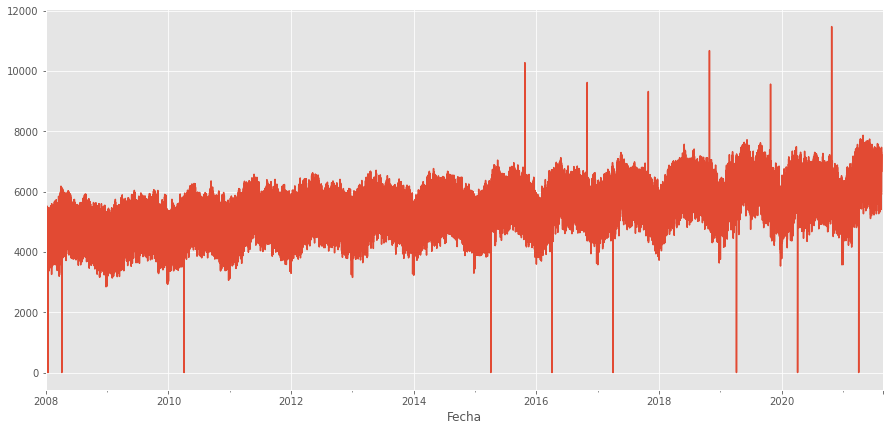

In [7]:
df.Demanda = pd.to_numeric(df.Demanda)
df.Demanda.plot(figsize=(15,7))

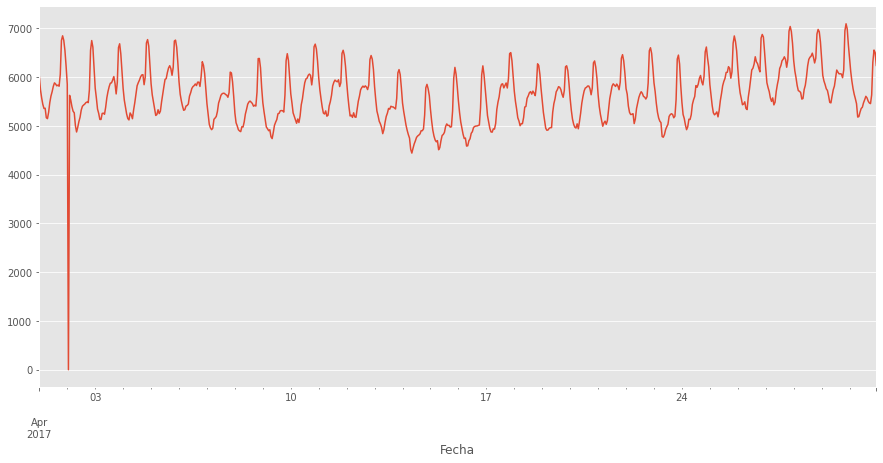

In [8]:
año = 2017
df[(df.index.year == año) & (df.index.month == 4)].Demanda.plot(figsize=(15,7))

Vamos a modificar los datos extremos debido al cambio de horario

In [9]:
df.loc[(df.Demanda > 8000) | (df.Demanda < 500), 'Demanda']

Fecha
2008-01-14 16:00:00        0.000
2008-04-06 01:00:00        0.000
2010-04-04 01:00:00        0.000
2015-04-05 01:00:00        0.000
2015-10-25 01:00:00    10279.148
2016-04-03 01:00:00        0.000
2016-10-30 01:00:00     9622.758
2017-04-02 01:00:00        0.000
2017-10-29 01:00:00     9324.478
2018-10-28 01:00:00    10680.191
2019-04-07 01:00:00        0.000
2019-10-27 01:00:00     9568.606
2020-04-05 01:00:00        0.000
2020-10-25 01:00:00    11477.831
2021-04-04 01:00:00        0.000
Name: Demanda, dtype: float64

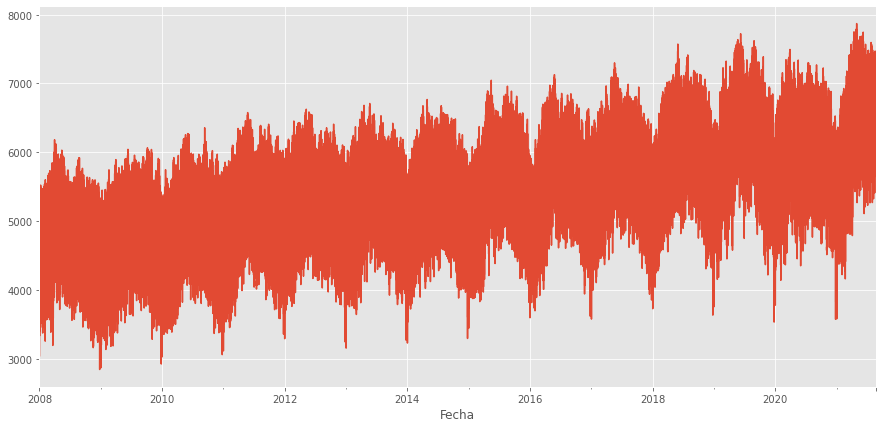

In [10]:
df.loc[(df.Demanda > 8000) | (df.Demanda < 500), 'Demanda'] = np.NaN
df.Demanda.fillna(method='pad', inplace=True)

df.Demanda.plot(figsize=(15,7))

In [18]:
# Vamos a asegurarnos que hay valor para todas las horas

df = df.asfreq('H', method='pad')

In [12]:
df.groupby(df.index.weekday).agg(
    {
        'Demanda': ['min', 'max', 'mean', 'median', 'std', 'mad']
    }
)

Demanda                                                          
            min       max         mean     median         std         mad
Fecha                                                                    
0      3161.000  7745.397  5195.223426  5167.7795  798.809545  654.173495
1      3035.000  7791.570  5275.559160  5261.3325  773.661357  628.855646
2      3228.629  7776.414  5315.349912  5298.6455  764.219553  622.902757
3      2844.000  7870.197  5316.189313  5296.4745  760.568432  620.489019
4      2951.800  7672.829  5296.493963  5285.3235  753.154241  612.896127
5      3059.945  7722.425  5180.637479  5153.7285  752.517642  611.744682
6      2923.765  7588.479  4896.984958  4834.7880  785.914935  635.453905

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


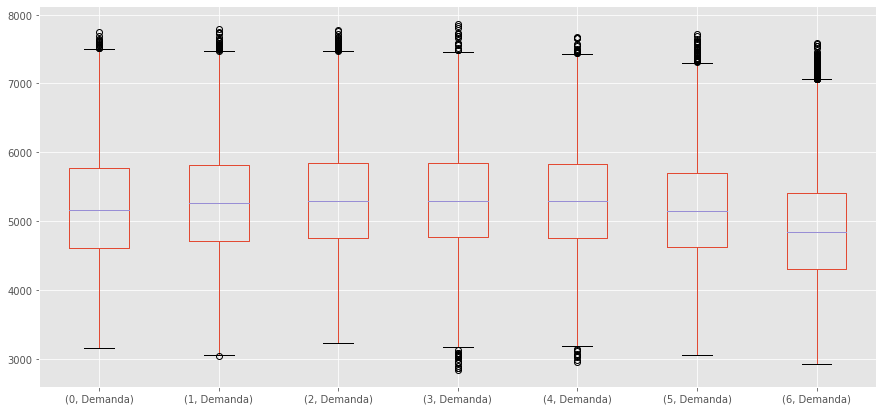

In [13]:
df[['Demanda']].groupby(df.index.weekday).boxplot(subplots=False, figsize=(15,7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


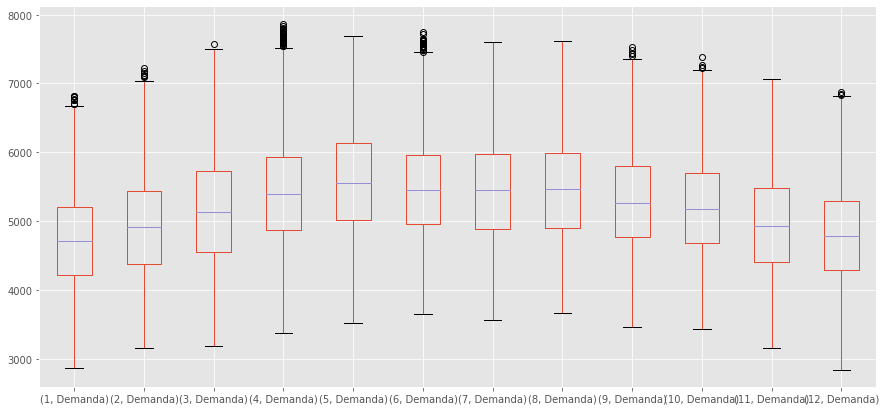

In [16]:
df[['Demanda']].groupby(df.index.month).boxplot(subplots=False, figsize=(15,7))

In [ ]:
df[['Demanda']].groupby(df.index.hour).boxplot(subplots=False, figsize=(15,7))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


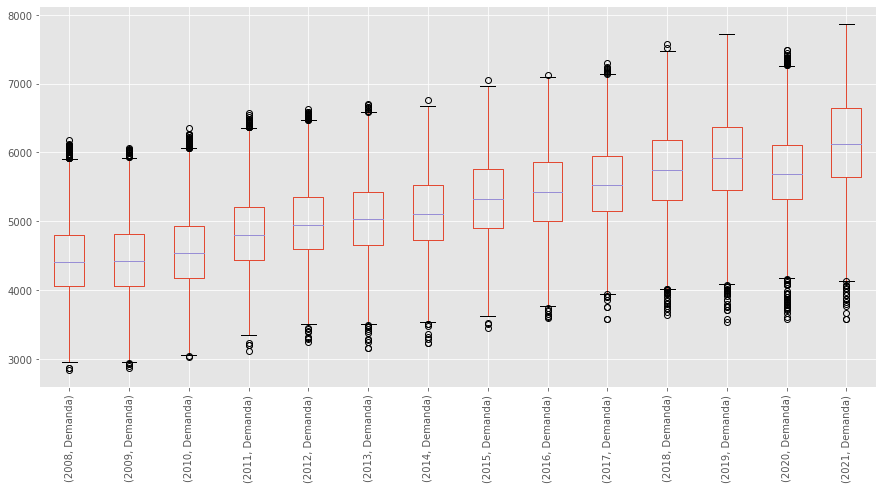

In [15]:
df[['Demanda']].groupby(df.index.year).boxplot(subplots=False, figsize=(15,7), rot=90)

## Forecasting


### 1. Encontrar los mejores parámetros 

In [45]:
df_train = df[df.index.year < 2021]
df_val = df[(df.index.year == 2021) & (df.index < pd.to_datetime('18/08/2021', format="%d/%m/%Y"))]

In [23]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
    regressor= Ridge(normalize=True),
    lags= 24 # Este valor será remplazado en el grid search
)

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-5, -1, 5)}

# Lags utilizados como predictores
lags_grid = [
  24, 
  [1, 2, 3, 24-1, 24, 24+1, 48-1, 48, 48+1],
  [1, 2, 3, 24-1, 24, 24+1, 48-1, 48, 48+1, 
   24 * 7 - 3, 24 * 7 - 2, 24 * 7 - 1, 24 * 7, 24 * 7 + 1, 24 * 7 + 2, 24 * 7 + 3]
]

resultados_grid = grid_search_forecaster(
    forecaster= forecaster,
    y= df_train.Demanda,
    param_grid= param_grid,
    lags_grid= lags_grid,
    steps= 36,
    metric= 'mean_absolute_error',
    method= 'backtesting',
    initial_train_size = len(df_train.Demanda[df_train.index.year < 2019]),
    return_best= True,
    verbose= False
)

2021-08-25 20:39:39,868 root       INFO  Number of models to fit: 15
loop lags_grid: 100%|██████████| 3/3 [00:31<00:00, 10.60s/it]
2021-08-25 20:40:11,667 root       INFO  Refitting `forecaster` using the best found parameters and the whole data set: 
lags: [  1   2   3  23  24  25  47  48  49 165 166 167 168 169 170 171] 
params: {'alpha': 1e-05}



In [25]:
resultados_grid

,lags,params,metric
10,"[1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 16...",{'alpha': 1e-05},162.150310
11,"[1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 16...",{'alpha': 0.0001},162.164146
12,"[1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 16...",{'alpha': 0.001},162.535427
13,"[1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 16...",{'alpha': 0.01},170.206579
14,"[1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 16...",{'alpha': 0.1},203.269632
7,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},207.358945
6,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.0001},207.479078
5,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 1e-05},207.552861
8,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.01},218.423908
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 1e-05},243.821320


In [26]:
forecaster

=======================ForecasterAutoreg=======================
Regressor: Ridge(alpha=1e-05, normalize=True)
Lags: [  1   2   3  23  24  25  47  48  49 165 166 167 168 169 170 171]
Exogenous variable: False
Parameters: {'alpha': 1e-05, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': True, 'random_state': None, 'solver': 'auto', 'tol': 0.001}

Para probar nuestro forcaster, tenemos que usar la función para estimar las 24 horas del día siguiente pero 12 horas antes.

In [27]:
def backtest_predict_next_24h(
    forecaster, y, hour_init_prediction, exog=None, verbose=False):
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.
    
    Parameters
    ----------
    forecaster : ForecasterAutoreg 
        ForecasterAutoreg object already trained.
        
    y : pd.Series with datetime index sorted
        Test time series values. 
        
    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable. 
    
    hour_init_prediction: int 
        Hour of day D to start predictions of day D+1.


    Returns 
    -------
    predictions: pd.Series
        Value of predictions.

    '''
    
    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()
        
    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24
    
    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break
    
    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predictions = []
    
    for i, day in enumerate(days_backtest):        
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]
               
        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")
                
            pred = forecaster.predict(steps=steps, last_window=last_window)
            
        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window.to_numpy()
            
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")
            
            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predictions of day D+1
        pred = pred[dummy_steps:]
        backtest_predictions.append(pred)
    
    backtest_predictions = np.concatenate(backtest_predictions)
    # Add datetime index
    backtest_predictions = pd.Series(
                             data  = backtest_predictions,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )
    
    return backtest_predictions

In [28]:
def mean_absolute_percent_error(y_true, y_pred):
  error = np.abs((y_true - y_pred) / y_true)
  return error.mean()

In [46]:
predicciones = backtest_predict_next_24h(
  forecaster= forecaster,
  y= df_val.Demanda,
  hour_init_prediction= 11,
  verbose= False
)

error_MAE = mean_absolute_error(
    y_true= df_val.loc[predicciones.index, 'Demanda'],
    y_pred= predicciones
)
error_MAPE = mean_absolute_percent_error(
    y_true= df_val.loc[predicciones.index, 'Demanda'],
    y_pred= predicciones
)

print(f"Error de backtest (MAE): {error_MAE}")
print(f"Error de backtest (MAPE): {error_MAPE}")

Backtesting starts at day: 2021-01-08 11:00:00
Days predicted in the backtesting: ['2021-01-09' '2021-01-10' '2021-01-11' '2021-01-12' '2021-01-13'
 '2021-01-14' '2021-01-15' '2021-01-16' '2021-01-17' '2021-01-18'
 '2021-01-19' '2021-01-20' '2021-01-21' '2021-01-22' '2021-01-23'
 '2021-01-24' '2021-01-25' '2021-01-26' '2021-01-27' '2021-01-28'
 '2021-01-29' '2021-01-30' '2021-01-31' '2021-02-01' '2021-02-02'
 '2021-02-03' '2021-02-04' '2021-02-05' '2021-02-06' '2021-02-07'
 '2021-02-08' '2021-02-09' '2021-02-10' '2021-02-11' '2021-02-12'
 '2021-02-13' '2021-02-14' '2021-02-15' '2021-02-16' '2021-02-17'
 '2021-02-18' '2021-02-19' '2021-02-20' '2021-02-21' '2021-02-22'
 '2021-02-23' '2021-02-24' '2021-02-25' '2021-02-26' '2021-02-27'
 '2021-02-28' '2021-03-01' '2021-03-02' '2021-03-03' '2021-03-04'
 '2021-03-05' '2021-03-06' '2021-03-07' '2021-03-08' '2021-03-09'
 '2021-03-10' '2021-03-11' '2021-03-12' '2021-03-13' '2021-03-14'
 '2021-03-15' '2021-03-16' '2021-03-17' '2021-03-18' '2021-0

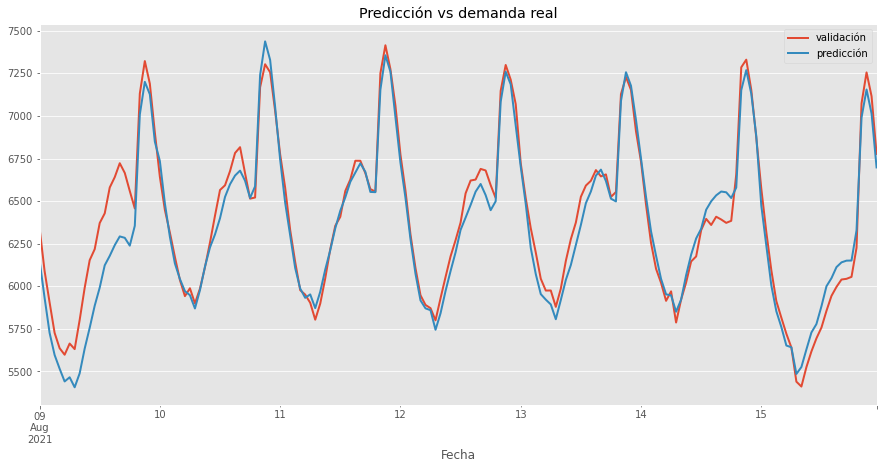

In [48]:
semana = 32

fig, ax = plt.subplots(figsize=(15, 7))

df_val.loc[ 
    df_val.index.isocalendar().week == semana, 'Demanda'
].plot(ax=ax, linewidth=2, label='validación')

predicciones[
    predicciones.index.isocalendar().week == semana
].plot(ax=ax, linewidth=2, label='predicción')

ax.set_title('Predicción vs demanda real')
ax.legend()
plt.show()

## Agregando variables exógenas


In [56]:
df.DIA = df.DIA.str.upper()
print(df.DIA[df.DIA.isna()])
df.loc[df.DIA.isna(), 'DIA'] = 'W'  # Es un solo día y es miércoles
df.DIA.unique()

Series([], Freq: H, Name: DIA, dtype: object)


array(['M', 'W', 'J', 'V', 'S', 'D', 'L'], dtype=object)

In [57]:
df['Hora'] = df.index.hour
df.Hora.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [65]:
import holidays

festivos = list(holidays.MEX(years=[2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]).keys())
df['Holiday'] = 1
df.Holiday.where(df.index.isin(festivos), 0, inplace=True)

In [66]:
df['Mes'] = df.index.month
df.Mes.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [68]:
# One hot encoding de las variables mes, hora y dia
df2=pd.get_dummies(df, columns=['Hora', 'DIA', 'Mes'])
df2

,Demanda,Holiday,Hora_0,Hora_1,Hora_2,Hora_3,Hora_4,Hora_5,Hora_6,Hora_7,Hora_8,Hora_9,Hora_10,Hora_11,Hora_12,Hora_13,Hora_14,Hora_15,Hora_16,Hora_17,Hora_18,Hora_19,Hora_20,Hora_21,Hora_22,Hora_23,DIA_D,DIA_J,DIA_L,DIA_M,DIA_S,DIA_V,DIA_W,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,Mes_8,Mes_9,Mes_10,Mes_11,Mes_12
Fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008-01-01 00:00:00,4312.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2008-01-01 01:00:00,4073.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2008-01-01 02:00:00,3867.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2008-01-01 03:00:00,3687.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2008-01-01 04:00:00,3514.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-24 19:00:00,7220.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2021-08-24 20:00:00,7220.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2021-08-24 21:00:00,7220.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [70]:
df_train = df2[df2.index.year < 2021]
df_val = df2[(df2.index.year == 2021) & (df2.index < pd.to_datetime('18/08/2021', format="%d/%m/%Y"))]

In [89]:
from sklearn.ensemble import RandomForestRegressor

forecasterX = ForecasterAutoreg(
    regressor= Ridge(alpha=1e-5, normalize=True),
    lags= [1, 2, 3, 23, 24, 25, 47, 48, 49, 165, 166, 167, 168, 169, 170, 171]
)

exog = [column for column in df2.columns 
        if column.startswith(('DIA', 'Hora', 'Mes', 'Holiday'))]

forecasterX.fit(y=df_train.Demanda, exog=df_train[exog].values)


In [90]:
predicciones = backtest_predict_next_24h(
  forecaster= forecasterX,
  y= df_val.Demanda,
  exog= df_val[exog],
  hour_init_prediction= 11,
  verbose= False
)

error_MAE = mean_absolute_error(
    y_true= df_val.loc[predicciones.index, 'Demanda'],
    y_pred= predicciones
)
error_MAPE = mean_absolute_percent_error(
    y_true= df_val.loc[predicciones.index, 'Demanda'],
    y_pred= predicciones
)

print(f"Error de backtest (MAE): {error_MAE}")
print(f"Error de backtest (MAPE): {error_MAPE}")

Backtesting starts at day: 2021-01-08 11:00:00
Days predicted in the backtesting: ['2021-01-09' '2021-01-10' '2021-01-11' '2021-01-12' '2021-01-13'
 '2021-01-14' '2021-01-15' '2021-01-16' '2021-01-17' '2021-01-18'
 '2021-01-19' '2021-01-20' '2021-01-21' '2021-01-22' '2021-01-23'
 '2021-01-24' '2021-01-25' '2021-01-26' '2021-01-27' '2021-01-28'
 '2021-01-29' '2021-01-30' '2021-01-31' '2021-02-01' '2021-02-02'
 '2021-02-03' '2021-02-04' '2021-02-05' '2021-02-06' '2021-02-07'
 '2021-02-08' '2021-02-09' '2021-02-10' '2021-02-11' '2021-02-12'
 '2021-02-13' '2021-02-14' '2021-02-15' '2021-02-16' '2021-02-17'
 '2021-02-18' '2021-02-19' '2021-02-20' '2021-02-21' '2021-02-22'
 '2021-02-23' '2021-02-24' '2021-02-25' '2021-02-26' '2021-02-27'
 '2021-02-28' '2021-03-01' '2021-03-02' '2021-03-03' '2021-03-04'
 '2021-03-05' '2021-03-06' '2021-03-07' '2021-03-08' '2021-03-09'
 '2021-03-10' '2021-03-11' '2021-03-12' '2021-03-13' '2021-03-14'
 '2021-03-15' '2021-03-16' '2021-03-17' '2021-03-18' '2021-0

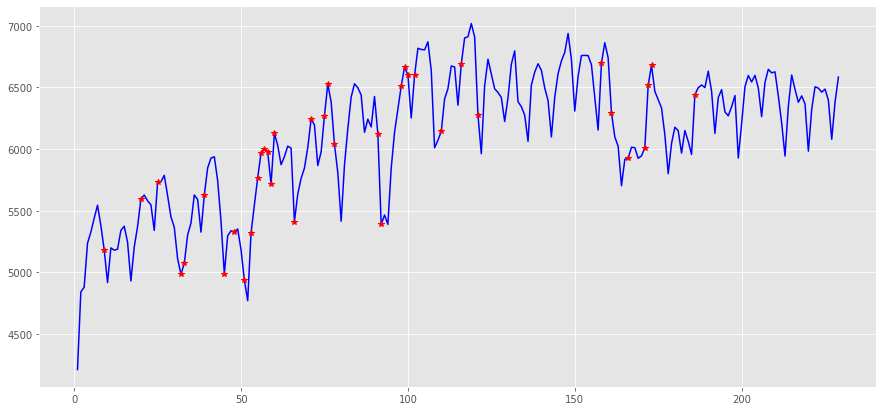

Hubo 37 días inaceptables


In [104]:
y_true= df_val.loc[predicciones.index, 'Demanda']
y_pred= predicciones

APE_hora = abs((y_true - y_pred) / y_pred)
APE_hora
MAPE_diario = APE_hora.groupby(APE_hora.index.day_of_year).mean()
inacceptable = MAPE_diario[MAPE_diario > 0.049]

dem_max_d = df_val.Demanda.groupby(df_val.index.day_of_year).mean()
ina_dem = dem_max_d[dem_max_d.index.isin(inacceptable.index)]


plt.figure(figsize=(15,7))
plt.plot(dem_max_d.index, dem_max_d.values, 'b')
plt.plot(ina_dem.index, ina_dem.values, '*r')
plt.show()

print(f"Hubo {len(inacceptable)} días inaceptables")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


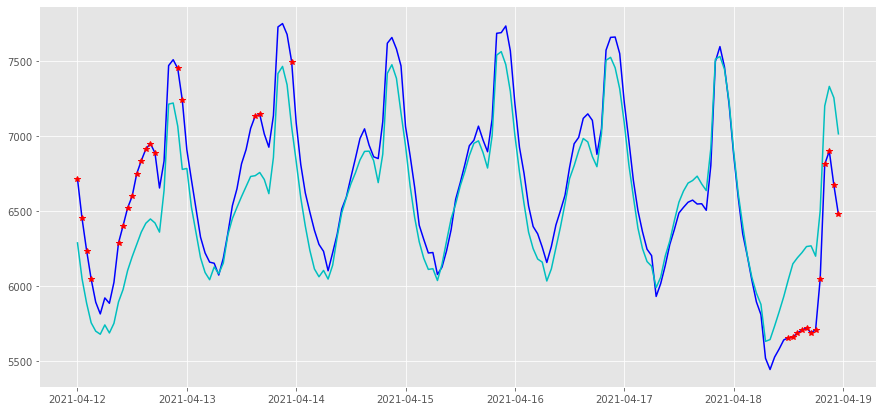

0.12100456621004566

In [117]:
semana = 15

ina_hora = APE_hora[APE_hora > 0.049]
dem_ina = df_val.Demanda[df_val.index.isin(ina_hora.index)] 

x = df_val[df_val.index.week == semana]
x_est = predicciones[predicciones.index.week == semana]
xa = dem_ina[dem_ina.index.week == semana]

plt.figure(figsize=(15,7))
plt.plot(x.index, x.Demanda, 'b')
plt.plot(x_est.index, x_est.values, 'c')
plt.plot(xa.index, xa.values, '*r')
plt.show()


len(ina_hora)

1060/(365*24)

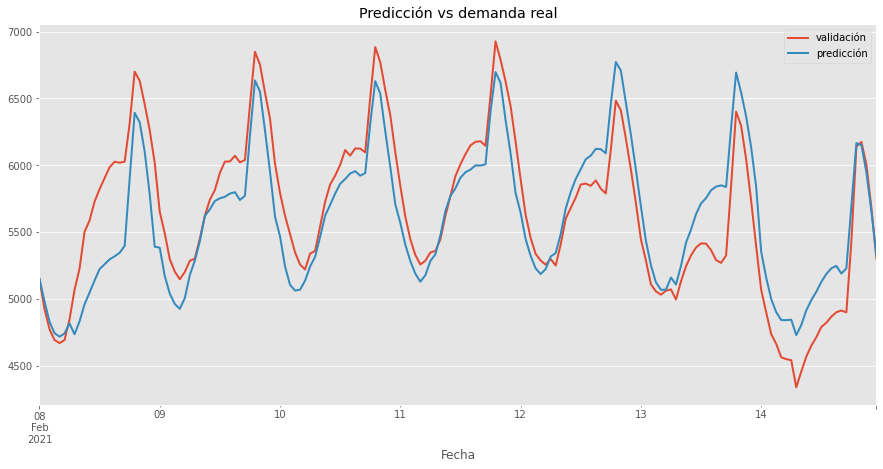

In [77]:
semana = 6

fig, ax = plt.subplots(figsize=(15, 7))

df_val.loc[ 
    df_val.index.isocalendar().week == semana, 'Demanda'
].plot(ax=ax, linewidth=2, label='validación')

predicciones[
    predicciones.index.isocalendar().week == semana
].plot(ax=ax, linewidth=2, label='predicción')

ax.set_title('Predicción vs demanda real')
ax.legend()
plt.show()